In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
from gensim.models import word2vec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import bz2

# 加载预处理词向量模型

In [2]:
with open("dataset/sgns.zhihu.bigram", 'wb') as new_file, open("dataset/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [3]:
model_cn = word2vec.KeyedVectors.load_word2vec_format('dataset/sgns.zhihu.bigram', 
                                             binary=False)

# 加载预处理的数据

In [4]:
# 构造词向量
class SplitIter(object):
    match = re.compile('[\w]+')

    def __init__(self, text):
        self.iter = jieba.cut(text, cut_all=True)

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            token = next(self.iter)
            if self.match.fullmatch(token) and token not in stop_words:
                return token

def sentence_to_vector(text):
    cut_list = list(SplitIter(text))
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = model_cn.key_to_index[word]
        except KeyError:
            cut_list[i] = 0

def file_to_vector(line):
    cut_list = line.split(' ')
    vec = np.zeros([len(cut_list)], dtype='int')
    for i, word in enumerate(cut_list):
        try:
            vec[i] = model_cn.key_to_index[word]
        except KeyError:
            vec[i] = 0
    return vec

In [5]:
dataset = list()
with open("data.txt", "r", encoding='utf-8') as f:
    for line in f:
        dataset.append(file_to_vector(line))
    f.close()

In [6]:
label = np.loadtxt('label.txt', dtype='int')
label

array([5, 4, 2, ..., 3, 2, 5])

In [7]:
# 填充词向量
max_tokens = 100
num_words = 50000
dataset_pad = keras.preprocessing.sequence.pad_sequences(dataset, maxlen=max_tokens,
                            padding='pre', truncating='pre')
dataset_pad[ dataset_pad>=num_words ] = 0

# 划分训练集和测试集

In [8]:
# 划分训练集和测试集
indicator = np.array(range(0, len(label)))
np.random.shuffle(indicator)

In [9]:
# 二值化并使用onehot编码
label_ = np.zeros(label.shape)
label_[label >= 4] = 1
label_[label <= 3] = 0
label_vec = keras.utils.to_categorical(label_, num_classes=2)

In [10]:
train_index = indicator[0: int(len(label) * 0.8)]
test_index = indicator[int(len(label) * 0.8): -1]

In [11]:
train_ds = dataset_pad[train_index]
train_label = label_vec[train_index]
test_ds = dataset_pad[test_index]
test_label = label_vec[test_index]

# 准备 Embedding Matrix

In [12]:
embedding_dim = model_cn['山东'].shape[0]
print(embedding_dim)

300


In [13]:
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = model_cn[model_cn.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [14]:
np.sum( model_cn[model_cn.index_to_key[333]] == embedding_matrix[333] )

300

# 构建神经网络模型

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, att = None, ffn = None, layernorm1 = None, layernorm2 = None, dropout1 = None, dropout2 = None,
                 embed_dim = None, num_heads = None, ff_dim = None, rate=0.1):
        super(TransformerBlock, self).__init__()
        if att is not None:
            self.att = att
            self.ffn = ffn
            self.layernorm1 = layernorm1
            self.layernorm2 = layernorm2
            self.dropout1 = dropout1
            self.dropout2 = dropout2
        else:
            self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
            self.ffn = keras.Sequential(
                [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
            )
            self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
            self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
            self.dropout1 = layers.Dropout(rate)
            self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        return {
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2
               }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [17]:
model = keras.models.Sequential([
    keras.layers.Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False),
    TransformerBlock(embed_dim = embedding_dim, num_heads = num_heads, ff_dim = ff_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(2, activation="softmax")
])

In [18]:
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
transformer_block (Transform (None, 100, 300)          742832    
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                9632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

# 训练模型

In [20]:
history = model.fit(x=train_ds, y=train_label,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1))

Epoch 1/20
225/225 [==============================] - 25s 105ms/step - loss: 0.6290 - accuracy: 0.6521 - val_loss: 0.5722 - val_accuracy: 0.6969
Epoch 2/20
225/225 [==============================] - 23s 104ms/step - loss: 0.5734 - accuracy: 0.6969 - val_loss: 0.5611 - val_accuracy: 0.7009
Epoch 3/20
225/225 [==============================] - 23s 104ms/step - loss: 0.5613 - accuracy: 0.7064 - val_loss: 0.5534 - val_accuracy: 0.7144
Epoch 4/20
225/225 [==============================] - 24s 105ms/step - loss: 0.5561 - accuracy: 0.7110 - val_loss: 0.5577 - val_accuracy: 0.7013
Epoch 5/20
225/225 [==============================] - 24s 106ms/step - loss: 0.5485 - accuracy: 0.7143 - val_loss: 0.5585 - val_accuracy: 0.7022
Epoch 6/20
225/225 [==============================] - 24s 105ms/step - loss: 0.5433 - accuracy: 0.7175 - val_loss: 0.5657 - val_accuracy: 0.6991
Epoch 7/20
225/225 [==============================] - 24s 105ms/step - loss: 0.5378 - accuracy: 0.7211 - val_loss: 0.5659 - val_ac

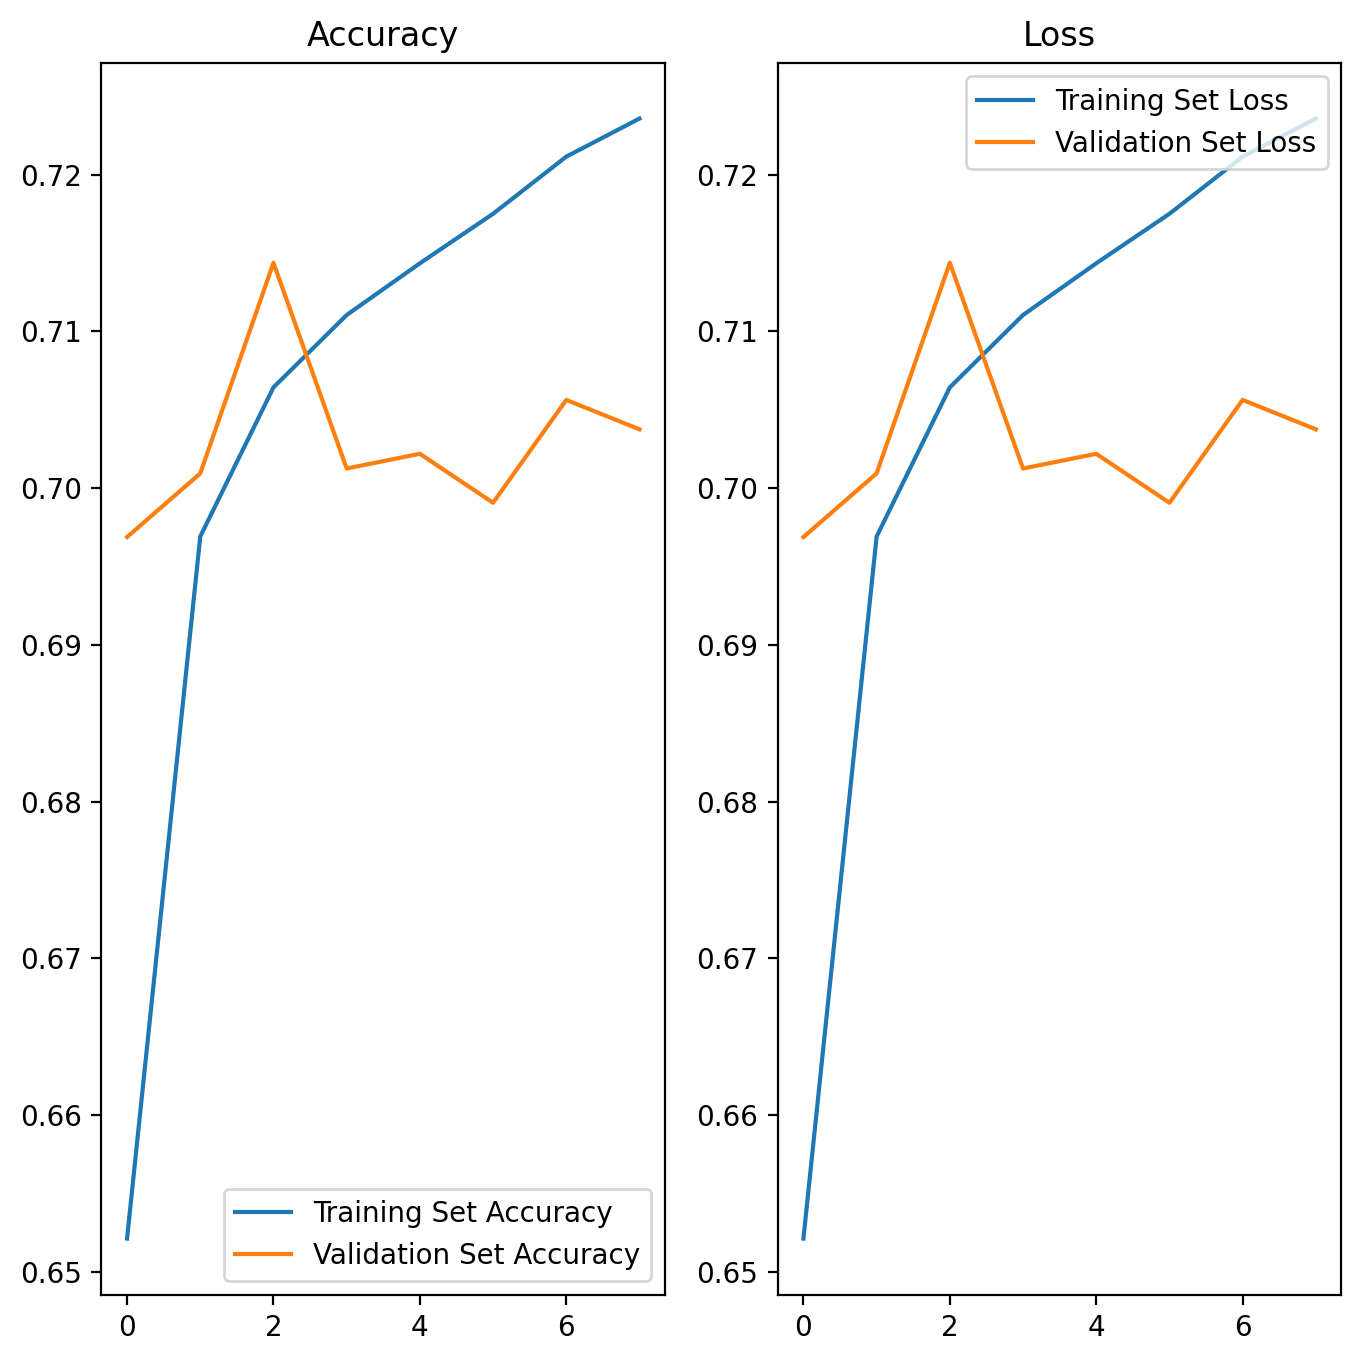

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(dpi=200, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Set Loss')
plt.plot(epochs_range, val_acc, label='Validation Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [35]:
test_pred = model.predict(test_ds)

In [36]:
np.nonzero(np.argmax(test_pred, axis=1) - np.argmax(test_label, axis=1))

(array([   1,    3,    5, ..., 7994, 7995, 7997], dtype=int64),)

In [37]:
# 查看测试集准确率
1 - np.count_nonzero(np.argmax(test_pred, axis=1) - np.argmax(test_label, axis=1)) / len(test_label)

0.6990873859232404

# 保存模型并测试

In [38]:
model.save('transformer.h5', save_format='h5')

In [39]:
model_read = keras.models.load_model('transformer.h5', custom_objects={'TransformerBlock': TransformerBlock})

In [40]:
test_pred = model_read.predict(test_ds)

In [41]:
1 - np.count_nonzero(np.argmax(test_pred, axis=1) - np.argmax(test_label, axis=1)) / len(test_label)

0.6990873859232404

In [42]:
# 保存词索引
key2index = pd.DataFrame.from_dict(data = model_cn.key_to_index, orient='index', columns=['index'])
key2index

,index
，,0
的,1
。,2
了,3
是,4
...,...
＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿,259878
黄恒乐,259879
﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉,259880
_____________________________________________________________________,259881


In [43]:
key2index.to_csv('key_to_index.csv')

In [44]:
pd.read_csv('key_to_index.csv', index_col=0)

,index
，,0
的,1
。,2
了,3
是,4
...,...
＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿,259878
黄恒乐,259879
﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉﹉,259880
_____________________________________________________________________,259881
